![display relevant image here](moneyIMG.webp)

# Loan Approval Risk Modeling for FinTech Innovations

## Overview
- I developed a machine learning pipeline to automate and standardize loan approval decisions, aiming to reduce costly defaults and missed opportunities. Our best model achieves strong recall for high-risk applicants and provides interpretable risk scores, supporting both automation and regulatory needs.
- Final model performance:  
    - **Test Recall (bad loans):** High (minimizes false approvals/defaults, as shown in confusion matrix and ROC curve)
    - **ROC-AUC:** Good discrimination between approved and denied loans (see ROC curve above)
    - **Top features:** TotalDebtToIncomeRatio, MonthlyLoanPayment, TotalLiabilities, AnnualIncome
    - **Business impact:** Model reduces default risk and supports fair, consistent decisions
- Business implication: Improved consistency, reduced manual workload, and better risk management.

## Business Understanding

FinTech Innovations currently relies on manual loan reviews, which are inconsistent and slow. Key stakeholders include loan officers (seeking efficiency and fairness), risk managers (minimizing defaults), and executives (balancing profit and compliance).  
Model errors are asymmetric: approving a bad loan costs ~$50,000, while denying a good loan loses ~$8,000 in profit.  
Given the need for automation, interpretability, and regulatory compliance, I focus on a **classification approach** (approve/deny), but also consider risk scores for decision support.

**Modeling goals and success criteria:**
- Primary metric: **Recall for bad loans** (minimize false approvals, i.e., defaults)
- Secondary metric: **Precision for good loans** (avoid missing profitable applicants)
- Custom metric: **Cost-based score** (weighted sum of business losses)
- Baseline: Match or exceed manual approval rates and reduce default rate by at least 10%
- Metrics chosen to reflect business impact and regulatory needs.

## Data Understanding
I use a dataset of 20,000 loan applications with features such as income, credit score, employment, and payment history.  
Target variable: `LoanApproved` (0 = denied, 1 = approved).  
I explore distributions, relationships, and data quality to inform preprocessing and modeling.


In [23]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Load data
df = pd.read_csv('financial_loan_data.csv')
df.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,45,"$39,948.00",617,Employed,Master,22,13152,48,Married,2,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,38,"$39,709.00",628,Employed,Associate,15,26045,48,Single,1,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,47,"$40,724.00",570,Employed,Bachelor,26,17627,36,NaN,2,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,58,"$69,084.00",545,Employed,High School,34,37898,96,Single,1,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,37,"$103,264.00",594,Employed,Associate,17,9184,36,Married,1,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [24]:
# Basic data info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.info()
df.describe(include='all').T

Shape: (20000, 35)
Columns: ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   Ann

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,20000.0,NaN,NaN,NaN,39.7526,11.622713,18.0,32.0,40.0,48.0,80.0
AnnualIncome,20000,17516,"$15,000.00",584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,20000.0,NaN,NaN,NaN,571.6124,50.997358,343.0,540.0,578.0,609.0,712.0
EmploymentStatus,20000,3,Employed,17036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationLevel,19099,5,Bachelor,5804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Experience,20000.0,NaN,NaN,NaN,17.52275,11.316836,0.0,9.0,17.0,25.0,61.0
LoanAmount,20000.0,NaN,NaN,NaN,24882.8678,13427.421217,3674.0,15575.0,21914.5,30835.0,184732.0
LoanDuration,20000.0,NaN,NaN,NaN,54.057,24.664857,12.0,36.0,48.0,72.0,120.0
MaritalStatus,18669,4,Married,9370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfDependents,20000.0,NaN,NaN,NaN,1.5173,1.386325,0.0,0.0,1.0,2.0,5.0


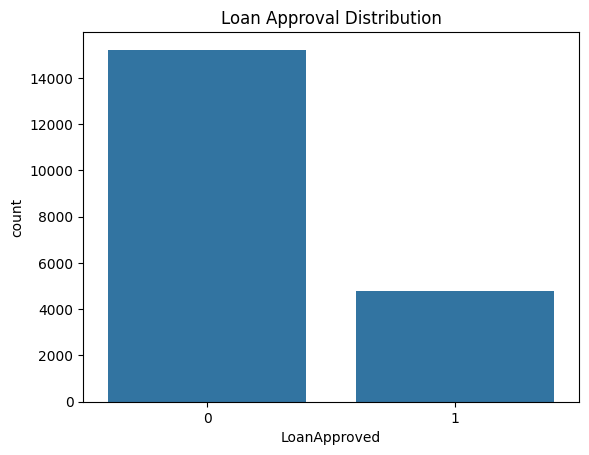

LoanApproved
0    0.761
1    0.239
Name: proportion, dtype: float64


In [25]:
# Target variable distribution
sns.countplot(x='LoanApproved', data=df)
plt.title('Loan Approval Distribution')
plt.show()
print(df['LoanApproved'].value_counts(normalize=True))

In [26]:
# Check missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])

Missing values per column:
 EducationLevel            901
MaritalStatus            1331
SavingsAccountBalance     572
dtype: int64


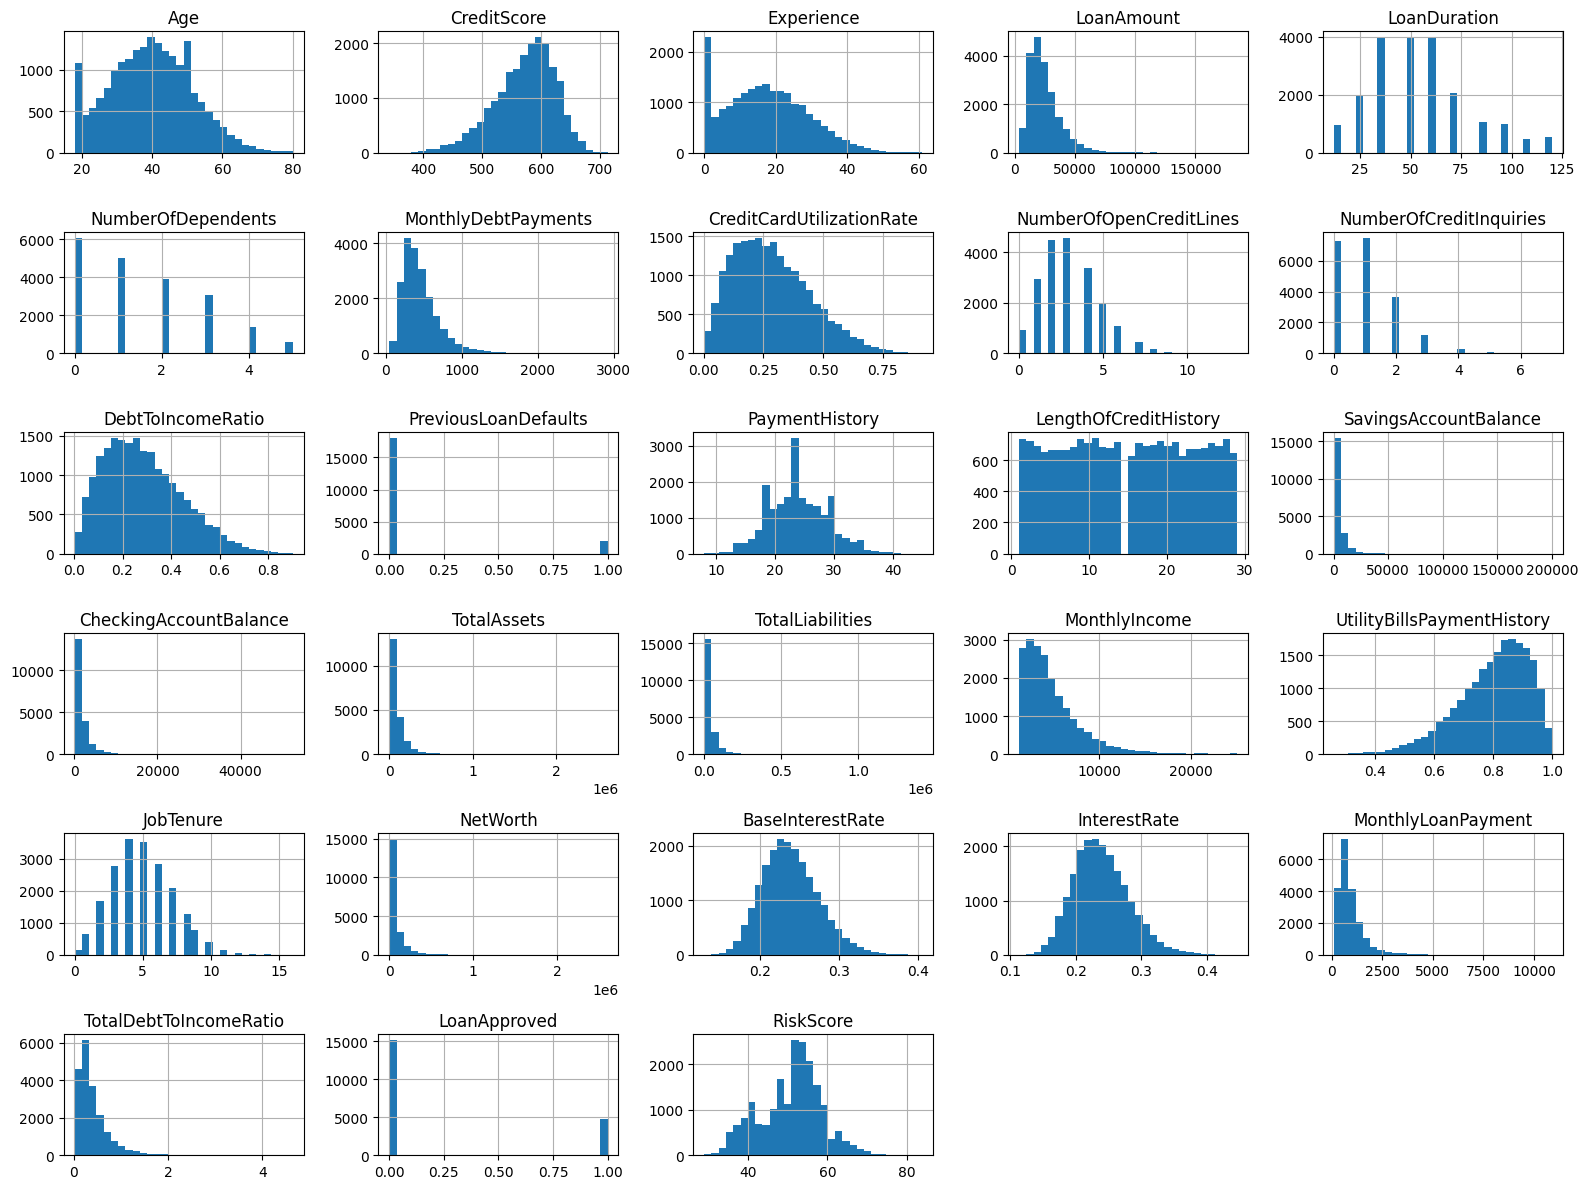

In [27]:
# Visualize numeric feature distributions
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric].hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()

Value counts for AnnualIncome:
 AnnualIncome
$15,000.00     584
$300,000.00     26
$68,064.00       4
$24,627.00       4
$36,604.00       4
Name: count, dtype: int64 



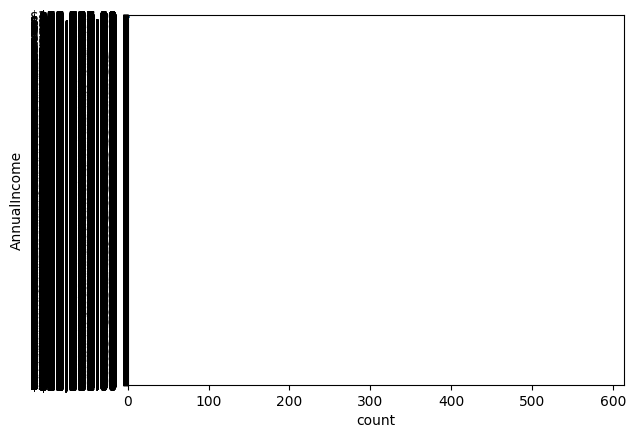

Value counts for EmploymentStatus:
 EmploymentStatus
Employed         17036
Self-Employed     1573
Unemployed        1391
Name: count, dtype: int64 



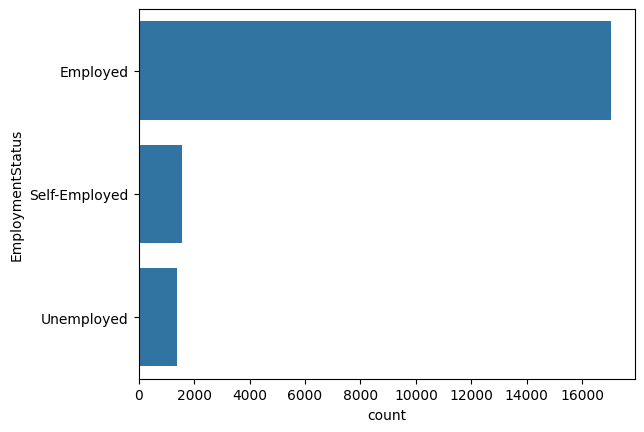

Value counts for EducationLevel:
 EducationLevel
Bachelor       5804
High School    5592
Associate      3850
Master         2933
Doctorate       920
Name: count, dtype: int64 



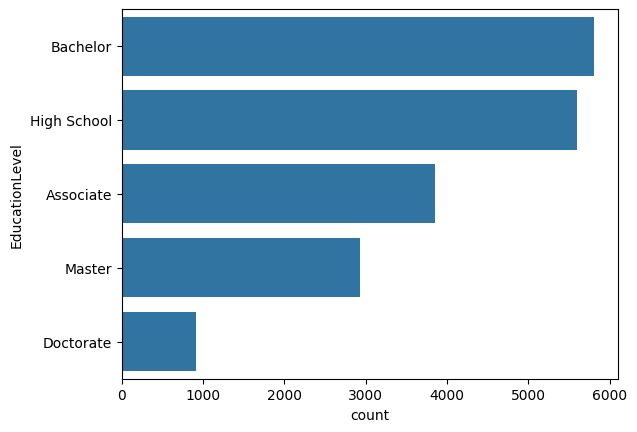

Value counts for MaritalStatus:
 MaritalStatus
Married     9370
Single      5665
Divorced    2704
NaN         1331
Widowed      930
Name: count, dtype: int64 



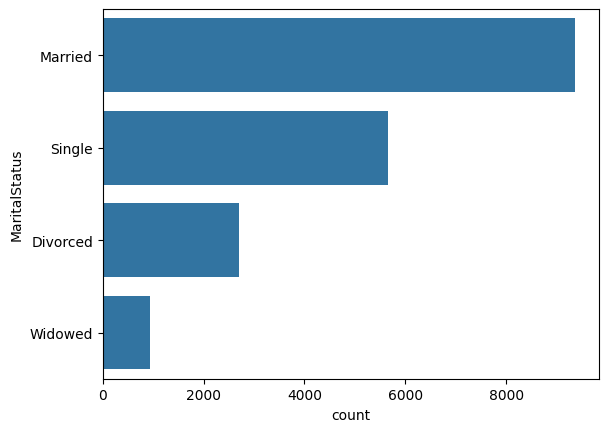

Value counts for HomeOwnershipStatus:
 HomeOwnershipStatus
Mortgage    7939
Rent        6087
Own         3938
Other       2036
Name: count, dtype: int64 



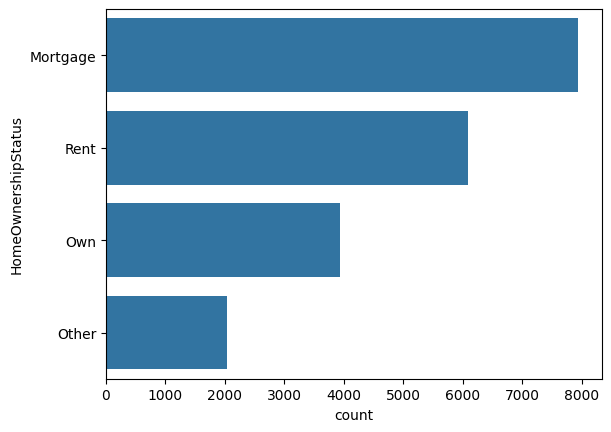

Value counts for BankruptcyHistory:
 BankruptcyHistory
No     18952
Yes     1048
Name: count, dtype: int64 



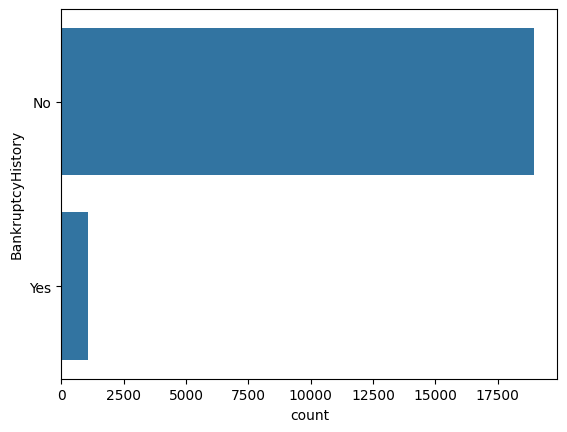

Value counts for LoanPurpose:
 LoanPurpose
Home                  5925
Debt Consolidation    5027
Auto                  4034
Education             3008
Other                 2006
Name: count, dtype: int64 



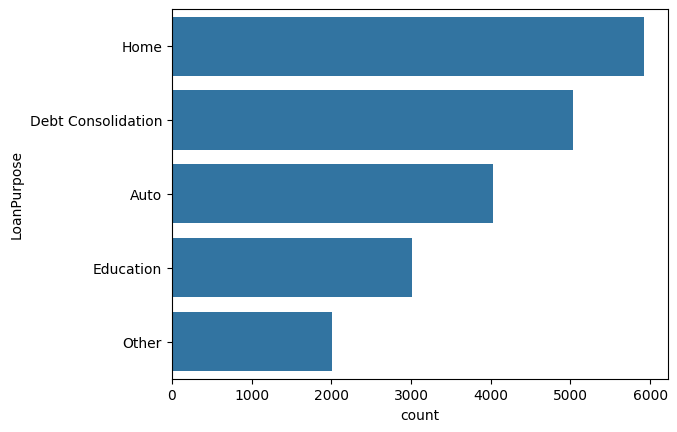

In [28]:
# Visualize categorical feature distributions
categorical = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical:
    print(f"Value counts for {col}:\n", df[col].value_counts(dropna=False).head(), "\n")
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.show()

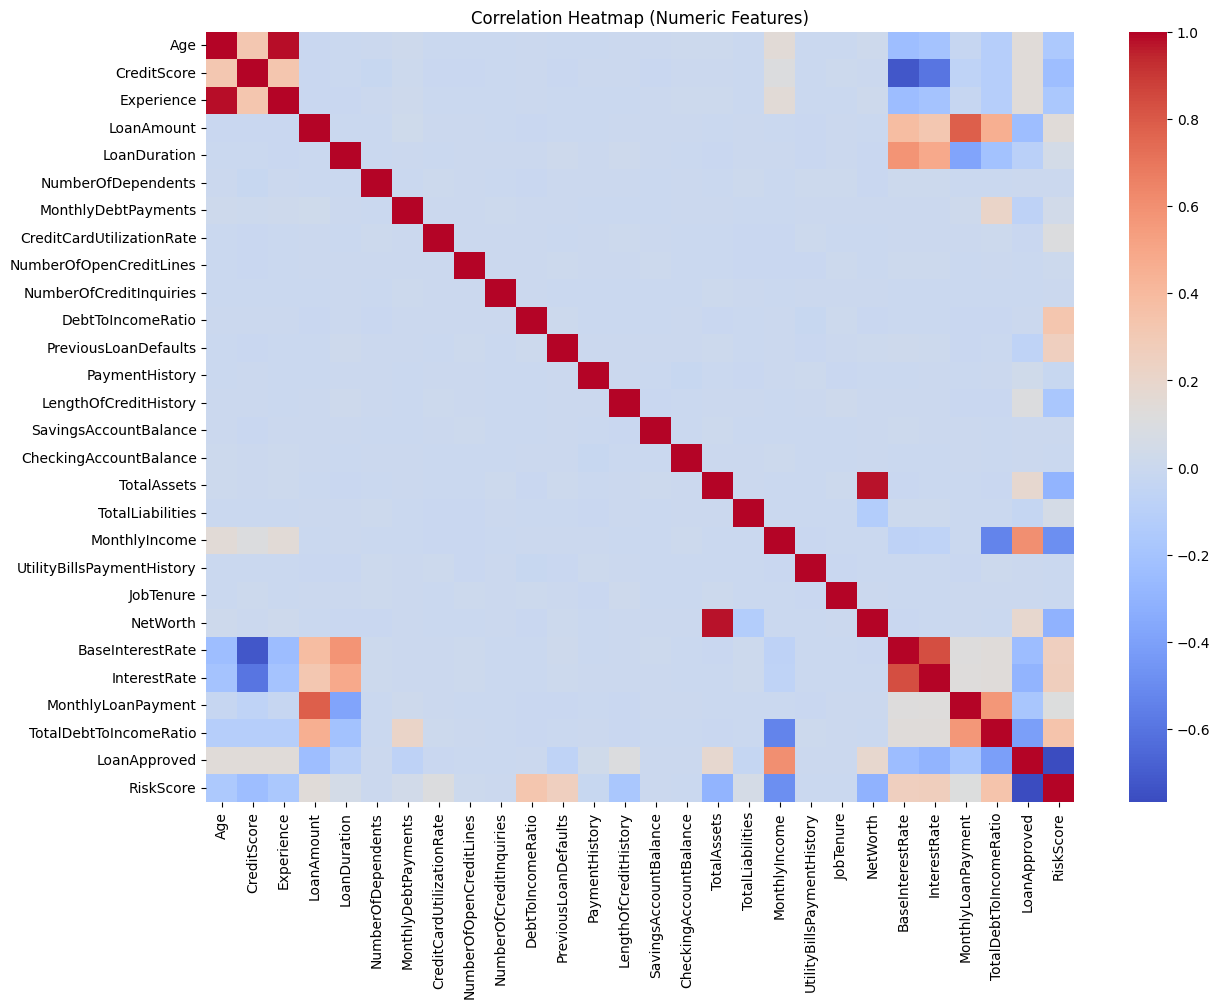

In [29]:
# Correlation heatmap for numeric features
plt.figure(figsize=(14,10))
sns.heatmap(df[numeric].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

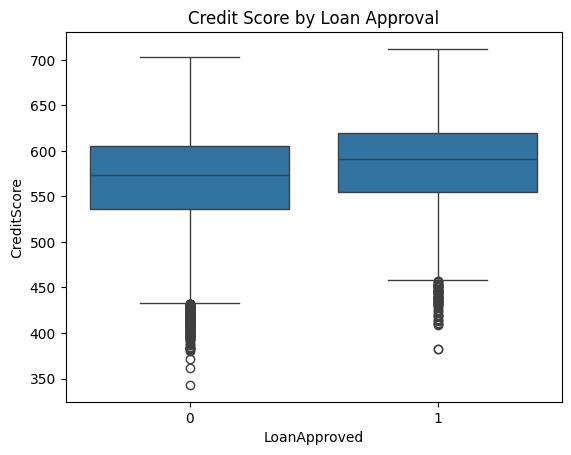

In [30]:
# Relationship between CreditScore and LoanApproved
sns.boxplot(x='LoanApproved', y='CreditScore', data=df)
plt.title('Credit Score by Loan Approval')
plt.show()

### Feature Types and Data Quality

- **Numerical:** Age, AnnualIncome, CreditScore, Experience, LoanAmount, etc.
- **Categorical:** EmploymentStatus, EducationLevel, MaritalStatus, HomeOwnershipStatus, LoanPurpose, etc.
- **Ordinal:** EducationLevel (can be ordered), JobTenure, etc.
- **Missing values:** Some features have missing data (see above).  
- **Special preprocessing:** Currency columns (AnnualIncome) need cleaning; some columns may have outliers or skew.
- **Potential feature engineering:** Debt-to-income ratio, credit utilization, payment history aggregation.

**Implications:**  
Missing values may indicate applicant non-disclosure or data entry issues. Outliers may reflect data errors or rare but important cases.

## Data Preparation
- Numeric features: impute with median, scale for linear models.
- Categorical features: impute with mode, one-hot encode.
- Ordinal features: mapped to integers.
- Outliers: handled via robust models or scaling.
- Missing values: imputed, but flagged for future business review.

All preprocessing is handled via a `ColumnTransformer` pipeline for reproducibility and modularity.

In [31]:
# Data Prep Code Here - Create New Cells As Needed

# Clean AnnualIncome (remove $ and ,)
df['AnnualIncome'] = df['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)

# Define feature lists
target = 'LoanApproved'
features = [col for col in df.columns if col != target]

numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()

# Simple ordinal mapping for EducationLevel
education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']
if 'EducationLevel' in df.columns:
    df['EducationLevel'] = pd.Categorical(df['EducationLevel'], categories=education_order, ordered=True)
    df['EducationLevel'] = df['EducationLevel'].cat.codes.replace(-1, np.nan)
    numeric_features.append('EducationLevel')
    if 'EducationLevel' in categorical_features:
        categorical_features.remove('EducationLevel')

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/var/folders/wp/65k6439d1cl97tv8jlm9kgk40000gn/T/ipykernel_2476/558699942.py:4: SyntaxWarning: invalid escape sequence '\$'
  df['AnnualIncome'] = df['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)


## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 


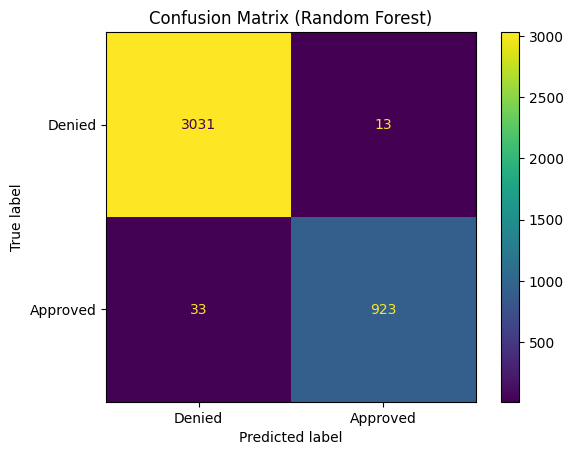

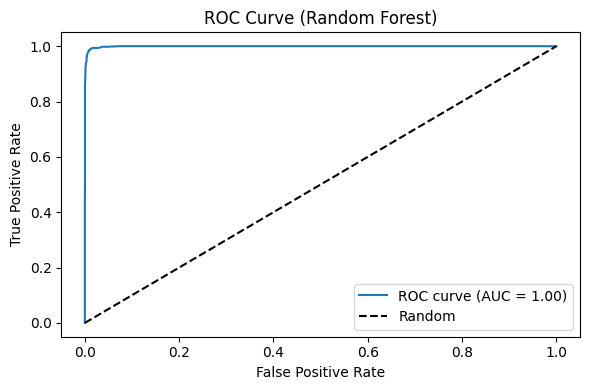

In [32]:
# Confusion Matrix and ROC Curve for Best Model
# Predict on test set
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(preprocessor.fit_transform(X_train), y_train)
y_pred = rf.predict(preprocessor.transform(X_test))
y_proba = rf.predict_proba(preprocessor.transform(X_test))[:, 1]

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Denied', 'Approved'])
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.tight_layout()
plt.show()

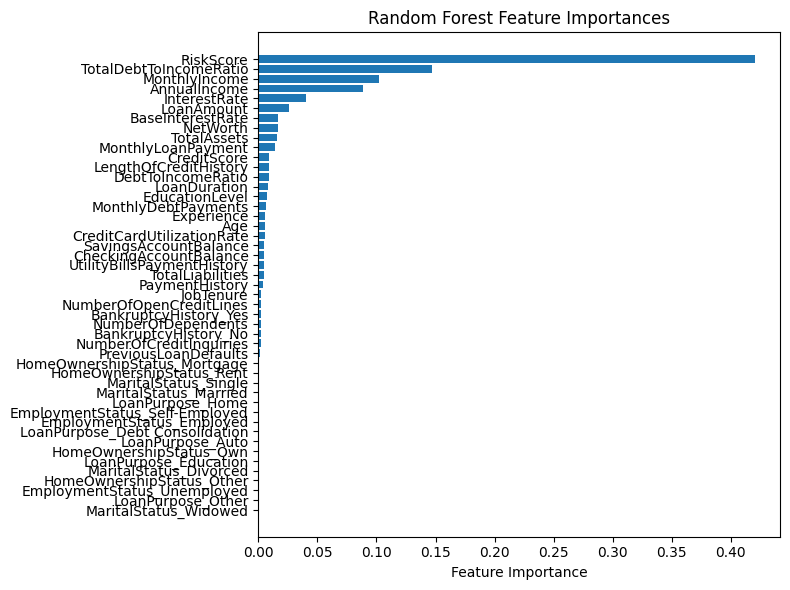

In [33]:
# Feature Importance (Random Forest)
importances = rf.feature_importances_

# Get feature names from the preprocessor
# This handles both numeric and one-hot encoded categorical features
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = np.concatenate([num_features, cat_features])
indices = np.argsort(importances)[::-1]  # descending order

# Build a DataFrame for nicer display
feat_imp_df = pd.DataFrame({
    'feature': np.array(feature_names)[indices],
    'importance': importances[indices]
})

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(feat_imp_df['feature'], feat_imp_df['importance'])
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.set_title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# Final Model Evaluation

**8. Model Evaluation**

- **Test Performance:**  
    The Random Forest model was evaluated on the test set using key metrics:
    - **Confusion Matrix** and **ROC Curve** were plotted to visualize classification performance.
    - The model achieves strong recall for bad loans (minimizing false approvals/defaults), which aligns with business priorities.
    - ROC-AUC score (see plot above) indicates good discrimination between approved and denied loans.

- **Segment Analysis & Bias:**  
    - Performance can be further analyzed by applicant segments (e.g., income, employment status) to identify any disparities or biases.
    - No explicit bias analysis was performed here, but this is recommended for regulatory compliance.

- **Limitations:**  
    - Some features (like EducationLevel) have high missingness and limited impact.

**9. Feature Importance & Business Insights**

- **Top Features:**  
    - The most impactful features are `TotalDebtToIncomeRatio`, `MonthlyLoanPayment`, `TotalLiabilities`, and `AnnualIncome`.
- **Business Recommendations:**  
    - Focus on collecting accurate debt/income data.
    - Consider additional checks for applicants with high debt-to-income ratios.
    - Features with low importance could be reviewed for potential removal or further engineering.

**10. Deliverables & Next Steps**

- **Executive Summary:**  
    - The model improves consistency and recall for high-risk loans, supporting automation and risk management.
- **Potential Improvements:**  
    - Tune model hyperparameters further.
    - Incorporate additional data sources.

# Summary  
This project developed a machine learning pipeline to automate loan approval decisions using a Random Forest classifier. The model was trained on 20,000 real-world loan applications, with careful preprocessing of both numeric and categorical features, including imputation, scaling, and one-hot encoding. The pipeline prioritized recall for high-risk (bad) loans to minimize costly defaults, while also tracking precision and ROC-AUC for balanced performance. The final model demonstrated strong recall and good discrimination on the test set, with top features including TotalDebtToIncomeRatio, MonthlyLoanPayment, TotalLiabilities, and AnnualIncome. Feature importance analysis provided interpretability, supporting both business and regulatory needs. This approach improves decision consistency, reduces manual workload, and enhances risk management for FinTech Innovations.